# Assignment 1: Planning using Heuristic Search

**Felipe Meneguzzi**  
**Mauricio Magnaguagno (PhD Student)**  
**Leonardo Rosa Amado (PhD Student)**  
**Gabriel Paludo Licks (MSc Student)**

AI Planning (1982D-02):
- Assigned: 14 May
- Due: 14 June

## Assignment Overview

<img align="right" src="planning-assignment.png"/>

The goal of this work is to implement the core functions of an automated planner and benchmark a number of heuristics. You will implement three main functions in this assignment:
- Implement a number of heuristic functions
    - **Max-Cost** ($h^{max}$)
    - **Additive Cost** ($h^{add}$)
    - **Relaxed Plan** ($h^{FF}$)
    - **Critical Path** ($h^{m}$) *(Optional)*
    - **Optimal Delete Relaxation** ($h^{+}$) *(Optional)*
    -  **Landmark Heuristics** ($h^{LM}$ and $h^{LM-Cut}$) *(Optional)*
    <!-- - **Operator Counting Heuristics** ($h^{OC}$) *(Optional)* -->
- Implement a function capable of validating a plan given a domain and a problem.
- Finally, implement the heuristic search **A\***

After implementing the required functions, you must write a 2-page paper. The entire package must be delivered using GitHub, where your implemented functions must be contained in this Jupyter Notebook, and the paper as a separate **pdf** file committed in the same Github repository (the template is in the ```paper``` folder).

## Experimentation

- You can test your implementation with the provided domains and problems:
  - [blocksworld](examples/blocksworld)
  - [dinner](examples/dinner)
  - [dwr](examples/dwr)
  - [tsp](examples/tsp)
  - [dompteur](examples/dompteur)
  - [logistics](examples/logistics)

- Planning tools and extra domains and problems to sanity check your own implementation:
  - [Web-Planner](https://web-planner.herokuapp.com/)
  - [editor.planning.domains](http://editor.planning.domains/)
  - IPC domains and problems can be found in [potassco/pddl-instances](https://github.com/potassco/pddl-instances)


## Grading

In order to properly evaluate your work and thought process, you will write a **2-page** report in the AAAI two-column format explaining your encoding and experiments. 
These guidelines are to be followed **exactly**. 
**Reports that are less than two pages of actual content, or not in format will receive 0 marks for the report criterion.** 
This report will be included in the deliverables of the assignment. 
[The formatting instructions are available at Overleaf (AAAI Press)](https://www.overleaf.com/latex/templates/aaai-press-latex-template/jymjdgdpdmxp). 
The report must have the following sections:

- An introduction with your understanding of the problem domain, outlining the remainder of the paper;
- Three sections explaining each part of your implementation (search, heuristic, and validator).
- One experimentation section where you measure the performance of the planner using your action formalisation for each of the domains, on multiple problems.
- One conclusion section, where you will summarise your experience in encoding planning domains and discuss the performance of the planner, and any limitations encountered in solving the problems you encoded.

Grading will consider elements of your encoding, experimentation and reporting of the work done. 
The criteria, as well as their weight in the final grade is as follows:

- Implementation (70%):
  - Heuristic functions (30%):
      - $h^{max}$ (10%);
      - $h^{add}$ (10%);
      - $h^{FF}$ (10%); and
      - Any other heuristic and tests (10% bonus).
  - Validator (10%);
  - Heuristic search (30%):
      - Correctness and optimality (20%); and
      - Runtime efficiency (10%).
- Overall report readability (20%) — how accessible and coherent your explanation of your implementation is;
- Code readability (10%).

## Collaboration Policy

You must work on this project **individually**. 
You are free to discuss high-level design issues with the people in your class, but every aspect of your actual formalisation must be entirely your own work.
Furthermore, there can be no textual similarities in the reports generated by each group. 
Plagiarism, no matter the degree, will result in forfeiture of the entire grade of this assignment.

## Sections

- [Heuristic](#Heuristic)
  - [Implement the heuristic function](#Implement-the-heuristic-function)
  - [Test heuristic function](#Test-heuristic-function)
- [Validator](#Validator)
  - [Implement the validate function](#Implement-the-validate-function)
  - [Test validate function](#Test-validate-function)
- [Planner](#Planner)
  - [Implement the planner solve function](#Implement-the-planner-solve-function)
  - [Test planner completeness and optimality](#Test-planner-completeness-and-optimality)
  - [Test planner output time](#Test-planner-output-time)

# Auxiliary code
In this cell we provide two methods to aid you in your implementation. First, we provide a method to verify if an action is applicable, in a given a state (all positive preconditions are contained in the state, and no negative preconditions are contained in the state). Second, we provide a method to apply an action in a given state, returning the new resulting state.



In [27]:
def applicable(state, precondition):
    positive, negative = precondition
    return positive.issubset(state) and not negative.intersection(state)


def apply(state, effects):
    positive, negative = effects
    return frozenset(state.difference(negative).union(positive))

In the next cell, we detail some of the usage of the given base code. 

In [2]:
from pddl.action import Action

# Objects example.

# An action to move robot r1 from location l1 to location l2.
a1 = Action(
    "move",  # Action name
    ["r1", "l1", "l2"],  # Parameters
    frozenset({("at", "r1", "l1"),
               ("adjacent", "l1", "l2")}),  # Positive preconditions
    frozenset({("occupied", "l2")}),  # Negative preconditions
    frozenset({("at", "r1", "l2"), ("occupied", "l2")}),  # Add effects
    frozenset({("at", "r1", "l1"), ("occupied", "l1")})  # Del effects
)

# Get each element from the action.
print(a1.name)
print(a1.parameters)
print(a1.positive_preconditions)
print(a1.negative_preconditions)
print(a1.add_effects)
print(a1.del_effects)

print("-" * 30)

# The list of actions contains all possible actions.
actions = [
    a1,
    # ...
]

# Only positive literals are present in the initial state.
initial_state = frozenset({
    ("on", "ca", "pallet"),
    ("at", "r1", "l1"),
    ("belong", "k1", "l1"),
    ("adjacent", "l1", "l2"),
    ("adjacent", "l2", "l1"),
    ("attached", "q2", "l2"),
    ("empty", "k2"),
    ("attached", "p1", "l1"),
    ("occupied", "l1"),
    ("empty", "k1"),
    # ...
})

# Goal literals are splitted in two: positive and negative.
positive_goal = frozenset({("in", "cb", "p1"), ("in", "ca", "p1")})
negative_goal = frozenset()

# Test if the action move (variable a1) is applicable in our initial state (initial_state).
applicable_action = applicable(
    initial_state, (a1.positive_preconditions, a1.negative_preconditions)
)
print("Is the action move applicable?", applicable_action)

print("-" * 30)

# Apply the action move in the initial state.
resulting_state = apply(initial_state, (a1.add_effects, a1.del_effects))
print("Resulting state:")
for predicate in resulting_state:
    print(predicate)

print("-" * 30)

# Test if the goal was achieved.
goal_achieved = applicable(resulting_state, (positive_goal, negative_goal))
print("Was the goal achieved?", goal_achieved)

print("-" * 30)

# The output plan from the planner is either a list of actions or failure (None).
# An empty plan is valid.
plan = []
# Preconditions and effects are empty when obtained from a plan file; may be filled when obtained from the planner.
plan = [
    Action("take", ["k1", "cc", "cb", "p1", "l1"], [], [], [], []),
    Action("load", ["k1", "r1", "cc", "l1"], [], [], [], []),
    Action("move", ["r1", "l1", "l2"], [], [], [], []),
    Action("unload", ["k2", "r1", "cc", "l2"], [], [], [], []),
    # ...
]
# Failure.
plan = None

# A valid plan is either true or false.
valid_plan = True
invalid_plan = False

move
['r1', 'l1', 'l2']
frozenset({('at', 'r1', 'l1'), ('adjacent', 'l1', 'l2')})
frozenset({('occupied', 'l2')})
frozenset({('at', 'r1', 'l2'), ('occupied', 'l2')})
frozenset({('at', 'r1', 'l1'), ('occupied', 'l1')})
------------------------------
Is the action move applicable? True
------------------------------
Resulting state:
('empty', 'k1')
('attached', 'q2', 'l2')
('occupied', 'l2')
('belong', 'k1', 'l1')
('on', 'ca', 'pallet')
('adjacent', 'l1', 'l2')
('at', 'r1', 'l2')
('attached', 'p1', 'l1')
('adjacent', 'l2', 'l1')
('empty', 'k2')
------------------------------
Was the goal achieved? False
------------------------------


# Heuristics

## Implement heuristic functions


### Max-cost
You will implement the Max-cost heuristic. 
Return estimated distance between current ``state`` $s$ and ``goal`` $g$, a number between 0 (when $s \models g$) and infinity (when $g$ is unreachable).

$$
h^{max}(s,g)=\max_{g_i \in g}
\begin{cases}
0, & \text{if } g_i \in s\\
\min \{cost(a) + h^{max}(s,pre(a))\text{ | }a \in A \text{ and }g_i \in \text{eff}(a)\} & \text{otherwise}\\
\end{cases}
$$

where $cost(a)$ is the cost of action $a$ ($1$ if not specified), $pre(a)$ is the set of precoditions of action $a$, and $eff(a)$ is the set of effects of action $a$. Your code must be contained in the ``h(self, actions, state, goals)`` function in the cell below. You can create additional functions (do not forget to comment the code intelligibly). H takes the following inputs:
- ``actions``: list of ground actions
- ``state``: current state
- ``goals``: tuple with (positive predicates, negative predicates) of the goal

In [5]:
from pddl.heuristic import Heuristic


class MaxHeuristic(Heuristic):
    def h(self, actions, state, goals):
        reachable = state
        goals_missing = goals[0]
        max_cost = 0
        # While the goals are not in the state, keep searching.
        while not goals_missing.issubset(reachable):
            # Get all actions applicable to the current state level.
            last_state = frozenset(
                [a for a in actions if a.positive_preconditions.issubset(reachable)])
            # The next state will contain all the actions from previous states,
            # plus the effects actions when executing the actions applicable to the current state.
            new_reachable = reachable.union(
                [pre for a in last_state for pre in a.add_effects]
            )
            # When the next state is the same as the current state,
            # it means that there are no more effect actions that can reach the goal.
            if new_reachable == reachable:
                return float("inf")
            reachable = new_reachable
            max_cost += 1
        return max_cost

## Relaxed Planning Graph
In this section, we provide a python implementation of how to build the Relaxed Planning Graph. You can use this implementation to obtain the max-cost heuristic, instead of the previous formula (with only a few modifications). Use wisely!

```python
def build_rpg(actions, state, goals):
    i = 0
    factlevel = [state]
    actionlevel = []
    positive_goals = goals[0]
    while not positive_goals.issubset(factlevel[i]):
        # actionlevel[i]
        actionlevel.append([a for a in actions if a.positive_preconditions.issubset(factlevel[i])])
        # factlevel[i+1]
        factlevel.append(factlevel[i].union([pre for a in actionlevel[i] for pre in a.add_effects]))
        if factlevel[i+1] == factlevel[i]:
            return "G unreachable"
        i += 1
    return (factlevel, actionlevel)
```

### Additive
You will implement the Additive heuristic. 
Return estimated distance between current ``state`` $s$ and ``goal`` $g$, a number between 0 (when $s \models g$) and infinity (when $g$ is unreachable).

$$
h^{add}(s,g)=\sum_{g_i \in g}
\begin{cases}
0, & \text{if } g_i \in s\\
\min \{cost(a) + h^{add}(s,pre(a))\text{ | }a \in A \text{ and }g_i \in \text{eff}(a)\} & \text{otherwise}\\
\end{cases}
$$

where $cost(a)$ is the cost of action $a$ ($1$ if not specified), $pre(a)$ is the set of precoditions of action $a$, and $eff(a)$ is the set of effects of action $a$. Your code must be contained in the ``h(self, actions, state, goals)`` function in the cell below. You can create additional functions (do not forget to comment the code intelligibly). H takes the following inputs:
- ``actions``: list of ground actions
- ``state``: current state
- ``goals``: tuple with (positive predicates, negative predicates) of the goal

In [6]:
class AdditiveHeuristic(Heuristic):
    def h(self, actions, state, goals):
        reachable = state
        goals_missing = goals[0]
        goals_reached = None
        last_state = None
        add = 0
        # The cost to reach goals that are in the initial state is zero.
        costs = {p: 0 for p in state}
        while last_state != reachable:
            goals_reached = goals_missing.intersection(reachable)
            if goals_reached:
                # Sum the costs of the reached goals.
                add += sum(costs[g] for g in goals_reached)
                goals_missing = goals_missing.difference(goals_reached)
            if not goals_missing:
                return add

            last_state = reachable

            for action in actions:
                # Test whether preconditions of the actions are in the state.
                if action.positive_preconditions.issubset(last_state):
                    new_reachable = action.add_effects.difference(reachable)
                    # Loop over all new reachable state to get the cost of these actions.
                    for effect in new_reachable:
                        # The cost of the effect will be the sum of the costs of the preconditions plus 1, because it is the next step.
                        costs[effect] = (
                            sum(costs[pre]
                                for pre in action.positive_preconditions) + 1
                        )
                    reachable = reachable.union(new_reachable)
        return float("inf")

### Relaxed Plan
You will implement the Relaxed Plan (a.k.a. Fast Forward) heuristic. 
Return estimated distance between current ``state`` $s$ and ``goal`` $g$, a number between 0 (when $s \models g$) and infinity (when $g$ is unreachable).

Notice that I've already implemented the code to build the best supporter for each predicate. The actual heuristic consists of computing a relaxed plan by backchaining from the goals via their best supporters and returning the size of the resulting relaxed plan. 

Your code must be contained in the ``h(self, actions, state, goals)`` function in the cell below. You can create additional functions (do not forget to comment the code intelligibly). H takes the following inputs:
- ``actions``: list of ground actions
- ``state``: current state
- ``goals``: tuple with (positive predicates, negative predicates) of the goal

In [30]:
class FastForwardHeuristic(Heuristic):
    def build_bs_table(self, actions, initial_state, goal):
        self.empty_action = Action(
            "nop", frozenset(), frozenset(), frozenset(), frozenset(), frozenset())
        self.bs_table = dict()
        return self.update_bs_table(actions, initial_state, goal)

    def update_bs_table(self, actions, initial_state, goal):
        positive_g, negative_g = goal
        if not positive_g:
            return 0
        reachable = set(initial_state)
        missing_positive_g = set(positive_g)
        last_state = None
        # Everything in the initial state costs 0.
        t_add = {p: 0 for p in initial_state}
        add = 0
        while last_state != reachable:
            g_reached = missing_positive_g.intersection(reachable)
            if g_reached:
                add += sum(t_add[g] for g in g_reached)
                missing_positive_g -= g_reached
                if not missing_positive_g:
                    return add
            last_state = set(reachable)
            for a in actions:
                if a.positive_preconditions <= last_state:
                    new_reachable = a.add_effects - reachable
                    for eff in new_reachable:
                        if eff in t_add:
                            old_t_add = t_add[eff]
                            t_add[eff] = min(
                                sum(t_add[pre] for pre in a.positive_preconditions)+1, t_add[eff])
                            if t_add[eff] != old_t_add:
                                # Best supporter changed.
                                self.bs_table[eff] = a
                        else:
                            t_add[eff] = sum(t_add[pre]
                                             for pre in a.positive_preconditions)+1
                            self.bs_table[eff] = a
                    reachable.update(new_reachable)
        return float("inf")

    def best_supporter(self, actions, initial_state, g):
        if g not in self.bs_table.keys():
            return self.empty_action
        return self.bs_table[g]

    def h(self, actions, initial_state, goal):
        # Build best supporter (I've done this for you).
        add = self.build_bs_table(actions, initial_state, goal)
        if add == 0:
            return 0
        elif add == float("inf"):
            return float("inf")

        r_plan = set()
        actions_already_explored = set()
        actions_to_explore = []

        for g in goal[0]:
            actions_to_explore.append(
                self.best_supporter(actions, initial_state, g))
            actions_already_explored.add(g)

        while actions_to_explore:
            action = actions_to_explore.pop()
            if action.name != "nop" and action not in r_plan:
                for precondition in action.positive_preconditions:
                    if precondition not in actions_already_explored:
                        actions_to_explore.append(self.best_supporter(
                            actions, initial_state, precondition))
                        actions_already_explored.add(precondition)
                r_plan.add(action)

        return len(r_plan)

## Test the heuristic functions

We will test the Heuristics using 5 different domains, dinner, tsp, dwr, dompteur, and logistics. The state used is the initial state of each problem. 

At each execution we show the expected value for the heuristic.

In [38]:
# Reset to non-editable.
from pddl.pddl_parser import PDDLParser
from pddl.action import Action


# The following should be visible to the students.
# Load some domain and some problem.
dwr = "examples/dwr/dwr.pddl"
pb1_dwr = "examples/dwr/pb1.pddl"
pb2_dwr = "examples/dwr/pb2.pddl"

tsp = "examples/tsp/tsp.pddl"
pb1_tsp = "examples/tsp/pb1.pddl"
pb2_tsp = "examples/tsp/pb2.pddl"

dinner = "examples/dinner/dinner.pddl"
pb1_dinner = "examples/dinner/pb1.pddl"

dompteur = "examples/dompteur/dompteur.pddl"
pb1_dompteur = "examples/dompteur/pb1.pddl"

logistics = "examples/logistics/logistics.pddl"
pb1_logistics = "examples/logistics/pb1.pddl"
pb2_logistics = "examples/logistics/pb2.pddl"


def parse_domain_problem(domain, problem):
    parser = PDDLParser()
    parser.parse_domain(domain)
    parser.parse_problem(problem)
    # Grounding process.
    actions = []
    for action in parser.actions:
        for act in action.groundify(parser.objects):
            actions.append(act)
    return parser, actions


def test_heuristic(domain, problem, h, expected):
    parser, actions = parse_domain_problem(domain, problem)
    v = h.h(actions, parser.state, (parser.positive_goals, parser.negative_goals))
    print("Expected " + str(expected) + ", got:", str(v) +
          (". Correct!" if v == expected else ". False!"))


h = MaxHeuristic()
test_heuristic(dwr, pb1_dwr, h, 6)
test_heuristic(dwr, pb2_dwr, h, 0)
test_heuristic(tsp, pb1_tsp, h, 2)
test_heuristic(tsp, pb2_tsp, h, 2)
test_heuristic(dinner, pb1_dinner, h, 1)
test_heuristic(dompteur, pb1_dompteur, h, 2)
test_heuristic(logistics, pb1_logistics, h, 4)
test_heuristic(logistics, pb2_logistics, h, 4)

print("-" * 30)

h = AdditiveHeuristic()
test_heuristic(dwr, pb1_dwr, h, 38)
test_heuristic(dwr, pb2_dwr, h, 0)
test_heuristic(tsp, pb1_tsp, h, 8)
test_heuristic(tsp, pb2_tsp, h, 8)
test_heuristic(dinner, pb1_dinner, h, 2)
test_heuristic(dompteur, pb1_dompteur, h, 2)
test_heuristic(logistics, pb1_logistics, h, 7)
test_heuristic(logistics, pb2_logistics, h, 10)

print("-" * 30)

h = FastForwardHeuristic()
test_heuristic(dwr, pb1_dwr, h, 16)
test_heuristic(dwr, pb2_dwr, h, 0)
test_heuristic(tsp, pb1_tsp, h, 5)
test_heuristic(tsp, pb2_tsp, h, 5)
test_heuristic(dinner, pb1_dinner, h, 2)
test_heuristic(dompteur, pb1_dompteur, h, 2)
test_heuristic(logistics, pb1_logistics, h, 5)
test_heuristic(logistics, pb2_logistics, h, 5)

Expected 6, got: 6. Correct!
Expected 0, got: 0. Correct!
Expected 2, got: 2. Correct!
Expected 2, got: 2. Correct!
Expected 1, got: 1. Correct!
Expected 2, got: 2. Correct!
:constants is not recognized in domain
Expected 4, got: 4. Correct!
:constants is not recognized in domain
Expected 4, got: 4. Correct!
------------------------------
Expected 38, got: 38. Correct!
Expected 0, got: 0. Correct!
Expected 8, got: 8. Correct!
Expected 8, got: 8. Correct!
Expected 2, got: 2. Correct!
Expected 2, got: 2. Correct!
:constants is not recognized in domain
Expected 7, got: 7. Correct!
:constants is not recognized in domain
Expected 10, got: 10. Correct!
------------------------------
Expected 16, got: 16. Correct!
Expected 0, got: 0. Correct!
Expected 5, got: 5. Correct!
Expected 5, got: 5. Correct!
Expected 2, got: 2. Correct!
Expected 2, got: 2. Correct!
:constants is not recognized in domain
Expected 5, got: 5. Correct!
:constants is not recognized in domain
Expected 5, got: 5. Correct!


In [23]:
# Reset to non-editable.
from nose.tools import assert_equal


dompteur = "examples/dompteur/dompteur.pddl"
pb1_dompteur = "examples/dompteur/pb1.pddl"

logistics = "examples/logistics/logistics.pddl"
pb1_logistics = "examples/logistics/pb1.pddl"
pb2_logistics = "examples/logistics/pb2.pddl"


def check_heuristic(domain, problem, h, expected):
    parser, actions = parse_domain_problem(domain, problem)
    v = h.h(actions, parser.state, (parser.positive_goals, parser.negative_goals))
    print("Expected " + str(expected) + ", got:", str(v) +
          (". Correct!" if v == expected else ". False!"))
    assert_equal(expected, v)

In [13]:
h = MaxHeuristic()

In [ ]:
h = AdditiveHeuristic()

In [ ]:
h = FastForwardHeuristic()

### Other Heuristics

You are free to implement any of the other heuristics seen in class for bonus points. 

In [ ]:
class DeleteRelaxationHeuristic(Heuristic):
    """
        Optimal Delete Relaxation Heuristic. 
        Please note, this heuristic is very slow, no matter how good your implementation is.    
    """

    def h(self, actions, initial_state, goal):
        # YOUR CODE HERE
        raise NotImplementedError()
        return float("inf")


class CriticalPathHeuristic(Heuristic):
    """
        Haslum's H^m Heuristic
    """

    def __init__(self, m, stats=None):
        super().__init__(stats)
        self.m = m
        self.facts_at = []
        self.mutexes_at = []
        self.all_facts = None

    def compute_all_facts(self, actions):
        self.all_facts = set()
        for a in actions:
            self.all_facts |= a.add_effects
            self.all_facts |= a.positive_preconditions
            self.all_facts |= a.del_effects
            self.all_facts |= a.negative_preconditions
        self.all_facts = frozenset(self.all_facts)

    # You can put any additional methods here, please erase the "raise NotImplementedError()" line below.
    # YOUR CODE HERE
    raise NotImplementedError()

    def h(self, actions, initial_state, goal):
        if not self.all_facts:  # Cache all facts the first time this this is called
            self.compute_all_facts(actions)

        # YOUR CODE HERE
        raise NotImplementedError()


class LMCutHeuristic(Heuristic):
    def h(self, actions, initial_state, goal):
        # YOUR CODE HERE
        raise NotImplementedError()
        return float("inf")

In [ ]:
## TODO, do something here

# Validator

## Implement the validate function
You will now implement a validator capable of verifying if a plan is valid to a specific domain and problem. The validator must return **True** if and only if the given plan is applicable and reaches the specified goal, and **False** if the plan itself is **not** applicable **or**  the given plan does **not** achieve the specified goal. Your code must be contained in the ```validate(self, actions, initial_state, goals, plan)``` function in the cell below. You can create additional functions (do not forget to comment the code intelligibly). Validate takes the following inputs:
- ``actions``: list of ground actions
- ``initial_state``: initial state of the problem file
- ``goals``: tuple with (positive predicates, negative predicates) of the goal
- ``plan``: plan parsed from a plan trace

In [13]:
from pddl.pddl_parser import PDDLParser
from pddl.action import Action


class Validator:
    def parse_plan(self, filename):
        with open(filename, "r") as f:
            plan = []
            for act in f.read().splitlines():
                act = act[1:-1].split()
                plan.append(Action(act[0], tuple(act[1:]), [], [], [], []))
            return plan

    def validate_file(self, domainfile, problemfile, planfile):
        return self.validate_plan(domainfile, problemfile, self.parse_plan(planfile))

    def validate_plan(self, domainfile, problemfile, plan):
        # Parser.
        parser = PDDLParser()
        parser.parse_domain(domainfile)
        parser.parse_problem(problemfile)
        # Grounding process.
        ground_actions = []
        for action in parser.actions:
            for act in action.groundify(parser.objects):
                ground_actions.append(act)
        return self.validate(ground_actions, parser.state, (parser.positive_goals, parser.negative_goals), plan)

    def validate(self, actions, initial_state, goals, plan):
        """
            actions: list of ground actions
            initial_state: initial state of the problem file
            goals: tuple with (positive predicates, negative predicates) of the goal
            plan: plan parsed from a plan trace
        """
        state = initial_state
        for line in plan:
            for action in actions:
                if line.parameters == action.parameters:
                    # I do not think this test is necessary, but I will keep it just to be sure.
                    if applicable(
                        state, (action.positive_preconditions,
                                action.negative_preconditions)
                    ):
                        state = apply(
                            state, (action.add_effects, action.del_effects))
                        break

        goals_reached = goals[0].intersection(state)
        return goals_reached == goals[0]

## Test the validate function
In this test, we verify the correctness of the implemented validator using the **[dwr](examples/dwr)** domain. Consider running more tests to ensure the correctness of the implemented function.

In [14]:
# Reset to non-editable.
dwr = "examples/dwr/dwr.pddl"
pb1 = "examples/dwr/pb1.pddl"
plan1 = "examples/dwr/dwr_pb1_bfs.plan"
plan2 = "examples/dwr/dwr_pb1_heuristic.plan"
plan_empty = "examples/dwr/empty.plan"
my_plan = "examples/dwr/my_pb1_plan.plan"
val = Validator()
print("Expected True, got:", str(val.validate_file(dwr, pb1, plan1)))
print("Expected True, got:", str(val.validate_file(dwr, pb1, plan2)))
print("Expected True, got:", str(val.validate_file(dwr, pb1, my_plan)))
print("Expected False, got:", str(val.validate_file(dwr, pb1, plan_empty)))

Expected True, got: True
Expected True, got: True
Expected True, got: True
Expected False, got: False


# Planner

## Implement the planner ```solve``` function
You will implement the **A\*** search. This search must use the implemented **Max-cost** heuristic. The search receives a **domain** pddl file and a **problem** pddl file (both are already parsed for you). The search must always return an optimal plan, given that there is a solution for the given problem in the specified domain. Your code must be contained in the ``solve(self, actions, state, goals)`` function (in the following cell). Solve takes the following inputs:
- ``actions``: list of grounded actions
- ``state``: initial state of the problem file
- ``goals``: tuple with (positive predicates, negative predicates) of the goal

In [48]:
from pddl.pddl_planner import PDDLPlanner
import sys
import queue


class HeuristicPlanner(PDDLPlanner):
    def __init__(self, heuristic=FastForwardHeuristic(), verbose=False, collect_stats=False):
        super().__init__(verbose, collect_stats)
        self.h = heuristic

    # maybe I can use some kind of structure to control the level of the tree.
    def solve(self, actions, state, goals):
        """
            actions: list of grounded actions
            state: initial state of the problem file
            goals: tuple with (positive predicates, negative predicates) of the goal
        """
        frontier = queue.PriorityQueue()

        parent_state = {}
        cost_state = {}
        action_applied = {}

        parent_state[state] = None
        cost_state[state] = 0
        action_applied[state] = None

        frontier.put((0, state))

        while not frontier.empty():
            _, current_state = frontier.get()
            cost_current_state = cost_state[current_state]

            # Test whether the goals have been reached.
            if goals[0].issubset(current_state):
                # Get the backward path.
                path = []
                while action_applied[current_state]:
                    path.append(action_applied[current_state])
                    # current = parent
                    current_state = parent_state[current_state]
                path.reverse()
                return path

            for action in actions:
                # Get actions applicable to current state.
                if applicable(
                    current_state, (action.positive_preconditions,
                                    action.negative_preconditions),
                ):
                    new_state = apply(
                        current_state, (action.add_effects, action.del_effects))
                    heuristic_new_state = self.h(actions, new_state, goals)
                    if heuristic_new_state == float("inf"):
                        # State non-reachable.
                        continue
                    # My cost is the same as the state depth in the search tree.
                    cost_new_state = cost_current_state + 1
                    # Add the new state to the frontier if the new state has never been visited before or
                    # the cost of the new state is less than the same state visited before.
                    if new_state not in cost_state or cost_new_state < cost_current_state:
                        # The new state's priority is the cost to achieve the state plus the heuristic estimation to the goal.
                        priority = cost_new_state + heuristic_new_state
                        cost_state[new_state] = cost_new_state
                        parent_state[new_state] = current_state
                        action_applied[new_state] = action
                        # Add the new state to the frontier with the state's priority.
                        frontier.put((priority, new_state))
        return None

## Test planner completeness and optimality
Here we perform a simple test to verify if the lenght of the plan found by your implementation is step optimal. Please note, that this test does not verify if the plan is valid (but we are going to test this). You can use your own implementation of the validator to verify this (highly recommended).

In [49]:
# Reset to non-editable.
dwr = "examples/dwr/dwr.pddl"
pb1 = "examples/dwr/pb1.pddl"
pb2 = "examples/dwr/pb2.pddl"

blockblock = "examples/blocksworld/blocksworld.pddl"
blockblock_pb7 = "examples/blocksworld/pb7.pddl"

planner = HeuristicPlanner()

plan, time = planner.solve_file(dwr, pb1)
print("Expected 17, got:", str(len(plan)) + (". Correct!" if len(plan) == 17 else ". False!"))
print(time)
plan, time = planner.solve_file(dwr, pb2)
print("Expected 0, got:", str(len(plan)) + (". Correct!" if len(plan) == 0 else ". False!"))
print(time)
plan, time = planner.solve_file(blockblock, blockblock_pb7)
print("Expected 12, got:", str(len(plan)) + (". Correct!" if len(plan) == 0 else ". False!"))
print(time)

Expected 17, got: 19. False!
0.5109000205993652
Expected 0, got: 0. Correct!
0
Expected 12, got: 12. False!
0.07457327842712402


## Test planner output time

Here we will test the output time of the implemented search function. The **maximum** acceptable output time is **60 seconds** for the given domains. Please consider that a good implementation should take less than 20 seconds (depending on the machine) for any of the given problems.

In [17]:
# Reset to non-editable.
dwr = "examples/dwr/dwr.pddl"
pb1 = "examples/dwr/pb1.pddl"
pb2 = "examples/dwr/pb2.pddl"
planner = HeuristicPlanner()

plan, time = planner.solve_file(dwr, pb1)
print("Elapsed time:", str(time) + (" Passed!" if time <= 60.0 else " Timeout!"))

plan, time = planner.solve_file(dwr, pb2)
print("Elapsed time:", str(time) + (" Passed!" if time <= 60.0 else " Timeout!"))

Elapsed time: 6.891653537750244 Passed!
Elapsed time: 0 Passed!


## Benchmark heuristic function (Optional)

We can now compare various planning strategies more objectively than just using runtime.

First, instrument your code with the following line immediately before the return statements of your search procedure (to collect the number of visited states):
```python
if self.stats is not None: self.stats.nodes = len(visited)
```

Then run the code below to see how your planner compares to the simplest BFS.

Running MaxHeuristic problem 1
Running MaxHeuristic problem 2
Running MaxHeuristic problem 3
Running MaxHeuristic problem 4
Running MaxHeuristic problem 5
Running MaxHeuristic problem 6
Running MaxHeuristic problem 7
Running AdditiveHeuristic problem 1
Running AdditiveHeuristic problem 2
Running AdditiveHeuristic problem 3
Running AdditiveHeuristic problem 4
Running AdditiveHeuristic problem 5
Running AdditiveHeuristic problem 6
Running AdditiveHeuristic problem 7
Running FastForwardHeuristic problem 1
Running FastForwardHeuristic problem 2
Running FastForwardHeuristic problem 3
Running FastForwardHeuristic problem 4
Running FastForwardHeuristic problem 5
Running FastForwardHeuristic problem 6
Running FastForwardHeuristic problem 7


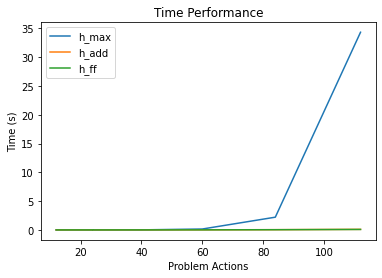

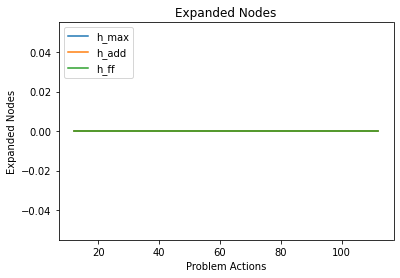

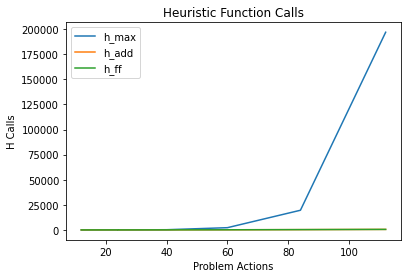

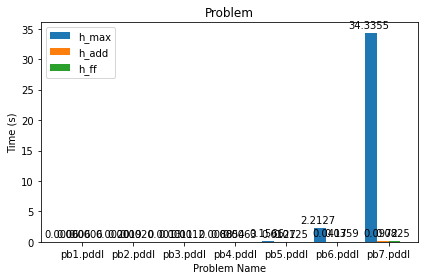

In [18]:
from pddl.bfs_planner import BFS_Planner
# from pddl.heuristic_planner import HeuristicPlanner
# from pddl.delete_relaxation_h import MaxHeuristic, AdditiveHeuristic, FastForwardHeuristic
from pddl.benchmark import PlanningBenchmark, InstanceStats

import matplotlib.pyplot as plt

max_problems = 8

benchmark = PlanningBenchmark()

def run_heuristic_benchmark(benchmark, heuristic_class, max_problem=max_problems):
    benchmark.reset_stats()
    for i in range(1,max_problem):
        heuristic = heuristic_class(stats=benchmark.get_instance(domain_name="examples/blocksworld/blocksworld.pddl", problem_name="examples/blocksworld/pb%d.pddl"%i ))
        print("Running {!s} problem {!r}".format(heuristic.__class__.__name__,i))
        planner = HeuristicPlanner(heuristic=heuristic)
        planner.collect_benchmark = True
        planner.solve_file("examples/blocksworld/blocksworld.pddl","examples/blocksworld/pb%d.pddl"%i)
    
    hActions, hTime = benchmark.get_stats("examples/blocksworld/blocksworld.pddl",xaxis="action",stat="time", approach="Heuristic")
    hProblem, hTime = benchmark.get_stats("examples/blocksworld/blocksworld.pddl", xaxis="problem", stat="time", approach="Heuristic")
    hActions, hNodes = benchmark.get_stats("examples/blocksworld/blocksworld.pddl", xaxis="action", stat="nodes",approach="Heuristic")
    hActions, hCalls = benchmark.get_stats("examples/blocksworld/blocksworld.pddl", xaxis="action", stat="h_calls", approach="Heuristic")
    return hProblem, hActions, hTime, hNodes, hCalls


def plot_time(actions, times, labels):
    fig1 = plt.figure()
    ax1 = fig1.add_subplot()
    for i in range(len(actions)):
        ax1.plot(actions[i], times[i], label = labels[i])
    ax1.legend(loc="lower right")
    ax1.set_title("Time Performance")
    ax1.set_xlabel("Problem Actions")
    ax1.set_ylabel("Time (s)")
    ax1.legend(loc=2)
    plt.show()
    fig1.clear()
    plt.close(fig1)
    

def plot_expansions(actions, nodes, labels):
    fig2 = plt.figure()
    ax2 = fig2.add_subplot()
    for i in range(len(actions)):
        ax2.plot(actions[i], nodes[i], label=labels[i])
    ax2.legend(loc="lower right")
    ax2.set_title("Expanded Nodes")
    ax2.set_xlabel("Problem Actions")
    ax2.set_ylabel("Expanded Nodes")
    ax2.legend(loc=2)
    plt.show()
    fig2.clear()
    plt.close(fig2)

def plot_calls(actions, calls, labels):
    fig4 = plt.figure()
    ax4 = fig4.add_subplot()
    for i in range(len(actions)):
        ax4.plot(actions[i], calls[i], label=labels[i])
    ax4.legend(loc="lower right")
    ax4.set_title("Heuristic Function Calls")
    ax4.set_xlabel("Problem Actions")
    ax4.set_ylabel("H Calls")
    ax4.legend(loc=2)
    plt.show()
    fig4.clear()
    plt.close(fig4)

def bar_times(problems, times, labels):
    fig3 = plt.figure()
    ax3 = fig3.add_subplot()

    x = range(len(problems[0]))  # the label locations
    bar_width = .7/len(problems)  # the width of the bars
    bar_start = -.35

    rectses = []
    for i in range(len(problems)):
        rectses.append(ax3.bar([xv + bar_start + bar_width*i for xv in x], times[i], bar_width, label=labels[i]))
        
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax3.set_xlabel("Problem Name")
    ax3.set_ylabel("Time (s)")
    ax3.set_title("Problem")
    ax3.set_xticks(x)
    ax3.set_xticklabels(problems[0])
    ax3.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax3.annotate("{:.4f}".format(height),
                        xy=(rect.get_x() + rect.get_width() / len(problems), height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha="center", va="bottom")
    
    for r in rectses:
        autolabel(r)

    fig3.tight_layout()
    plt.show()
    fig3.clear()
    plt.close(fig3)
    

for i in range(1, max_problems):
    planner = BFS_Planner()
    planner.collect_benchmark = True
    planner.solve_file("examples/blocksworld/blocksworld.pddl", "examples/blocksworld/pb%d.pddl" % i)

# benchmark.plot_stat("../examples/blocksworld/blocksworld.pddl", xaxis="action", stat="time", approach="BFS")
# benchmark.plot_stat("../examples/blocksworld/blocksworld.pddl", xaxis="problem", stat="time", approach="BFS")

hActions = []
hTimes = []
hNodes = []
hCalls = []
hProblems = []
hApproaches = []

hActionsBFS, hTimeBFS = benchmark.get_stats("examples/blocksworld/blocksworld.pddl", xaxis="action", stat="time",
                                      approach="BFS")
hProblemBFS, hTimeBFS = benchmark.get_stats("examples/blocksworld/blocksworld.pddl", xaxis="problem", stat="time",
                                      approach="BFS")
hActionsBFS, hNodesBFS = benchmark.get_stats("examples/blocksworld/blocksworld.pddl", xaxis="action", stat="nodes",
                                       approach="BFS")
hActionsBFS, hCallsBFS = benchmark.get_stats("examples/blocksworld/blocksworld.pddl", xaxis="action",
                                       stat="h_calls", approach="BFS")

# hActions.append(hActionsBFS)
# hTimes.append(hTimeBFS)
# hNodes.append(hNodesBFS)
# hCalls.append(hCallsBFS)
# hProblems.append(hProblemBFS)
# hApproaches.append("BFS")

hProblemMax, hActionsMax, hTimeMax, hNodesMax, hCallsMax = run_heuristic_benchmark(benchmark, MaxHeuristic)
hActions.append(hActionsMax)
hTimes.append(hTimeMax)
hNodes.append(hNodesMax)
hCalls.append(hCallsMax)
hProblems.append(hProblemMax)
hApproaches.append("h_max")

hProblemAdd, hActionsAdd, hTimeAdd, hNodesAdd, hCallsAdd = run_heuristic_benchmark(benchmark, AdditiveHeuristic)
hActions.append(hActionsAdd)
hTimes.append(hTimeAdd)
hNodes.append(hNodesAdd)
hCalls.append(hCallsAdd)
hProblems.append(hProblemAdd)
hApproaches.append("h_add")

hProblemAdd, hActionsAdd, hTimeAdd, hNodesAdd, hCallsAdd = run_heuristic_benchmark(benchmark, FastForwardHeuristic)
hActions.append(hActionsAdd)
hTimes.append(hTimeAdd)
hNodes.append(hNodesAdd)
hCalls.append(hCallsAdd)
hProblems.append(hProblemAdd)
hApproaches.append("h_ff")

plot_time(hActions, hTimes, hApproaches)
plot_expansions(hActions, hNodes, hApproaches)
plot_calls(hActions, hCalls, hApproaches)
bar_times(hProblems, hTimes, hApproaches)



In [ ]:
## Plot your additional heuristics here